## Example usage of PhaseNeXt (PhaseNeXt models trained on JMA unified data)

last update on 2025.11.01

### Example environment (2025-11-01)
- Environment: Python 3.13.1
- `torch` 2.5+
- `numpy` 2.1+
- `matplotlib` 3.9+

### Imports

In [4]:
from pathlib import Path

import h5py
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from models02.model_PhaseNeXtS import UseModel as PhaseNeXtS
from models02.model_PhaseNeXtM import UseModel as PhaseNeXtM
from models02.model_base import UseModel as BaseModel

from torchinfo import summary

plt.rcParams["figure.figsize"] = (12, 6)

### Load and standardize sample waveforms

In [2]:
# load data (MATLAB v7.3 matfile = HDF5 file)
filename = 'data/sample_wv.mat'
with h5py.File(filename, 'r') as file:
    wv = file['wv'][()]
wv = wv.transpose(2, 1, 0).astype(np.float32)

# PhaseNeXtの入力波形は4096 samples固定なので、足りない分は0-paddingする
pad_length = 4096 - wv.shape[2]
if pad_length > 0:
    wv = np.pad(wv, ((0, 0), (0, 0), (0, pad_length)), mode='constant', constant_values=0)
    
# standardization
mean = np.mean(wv, axis=2, keepdims=True)
std = np.std(wv, axis=2, keepdims=True)
wv = (wv - mean) / std

wv_tensor = torch.from_numpy(wv)

### Load PhaseNeXt models and weights

In [6]:
phase_next_S = PhaseNeXtS()
phase_next_S.load_state_dict(torch.load( "models02/model_PhaseNeXtS.pt", map_location="cpu"))

phase_next_M = PhaseNeXtM()
phase_next_M.load_state_dict(torch.load( "models02/model_PhaseNeXtM.pt", map_location="cpu"))

base_model = BaseModel()
base_model.load_state_dict(torch.load( "models02/model_base.pt", map_location="cpu"))

# Display architecture
summary(phase_next_M)

Layer (type:depth-idx)                   Param #
UseModel                                 --
├─ConvNeXtBlock: 1-1                     --
│    └─Conv1d: 2-1                       21
│    └─Sequential: 2-2                   --
│    │    └─Conv1d: 3-1                  48
│    │    └─GELU: 3-2                    --
│    └─Sequential: 2-3                   --
│    │    └─Conv1d: 3-3                  156
│    └─Conv1d: 2-4                       36
├─ConvNeXtBlock: 1-2                     --
│    └─Conv1d: 2-5                       84
│    └─Sequential: 2-6                   --
│    │    └─Conv1d: 3-4                  624
│    │    └─GELU: 3-5                    --
│    └─Sequential: 2-7                   --
│    │    └─Conv1d: 3-6                  588
│    └─Identity: 2-8                     --
├─ConvNeXtBlock: 1-3                     --
│    └─Conv1d: 2-9                       84
│    └─Sequential: 2-10                  --
│    │    └─Conv1d: 3-7                  624
│    │    └─GELU: 3-8  

### Run inference

In [4]:
# apply models
phase_next_S.eval()
with torch.no_grad():
    pred_NeXtS = phase_next_S(wv_tensor)
    # Modelがsoftmaxを含まないので，最後にかける必要がある．
    pred_NeXtS = F.softmax(pred_NeXtS, dim=1).detach().numpy()
    
phase_next_M.eval()
with torch.no_grad():
    pred_NeXtM = phase_next_M(wv_tensor)
    # Modelがsoftmaxを含まないので，最後にかける必要がある．
    pred_NeXtM = F.softmax(pred_NeXtM, dim=1).detach().numpy()

base_model.eval()
with torch.no_grad():
    pred_base = base_model(wv_tensor)
    # Modelがsoftmaxを含まないので，最後にかける必要がある．
    pred_base = F.softmax(pred_base, dim=1).detach().numpy()

### Plot predictions

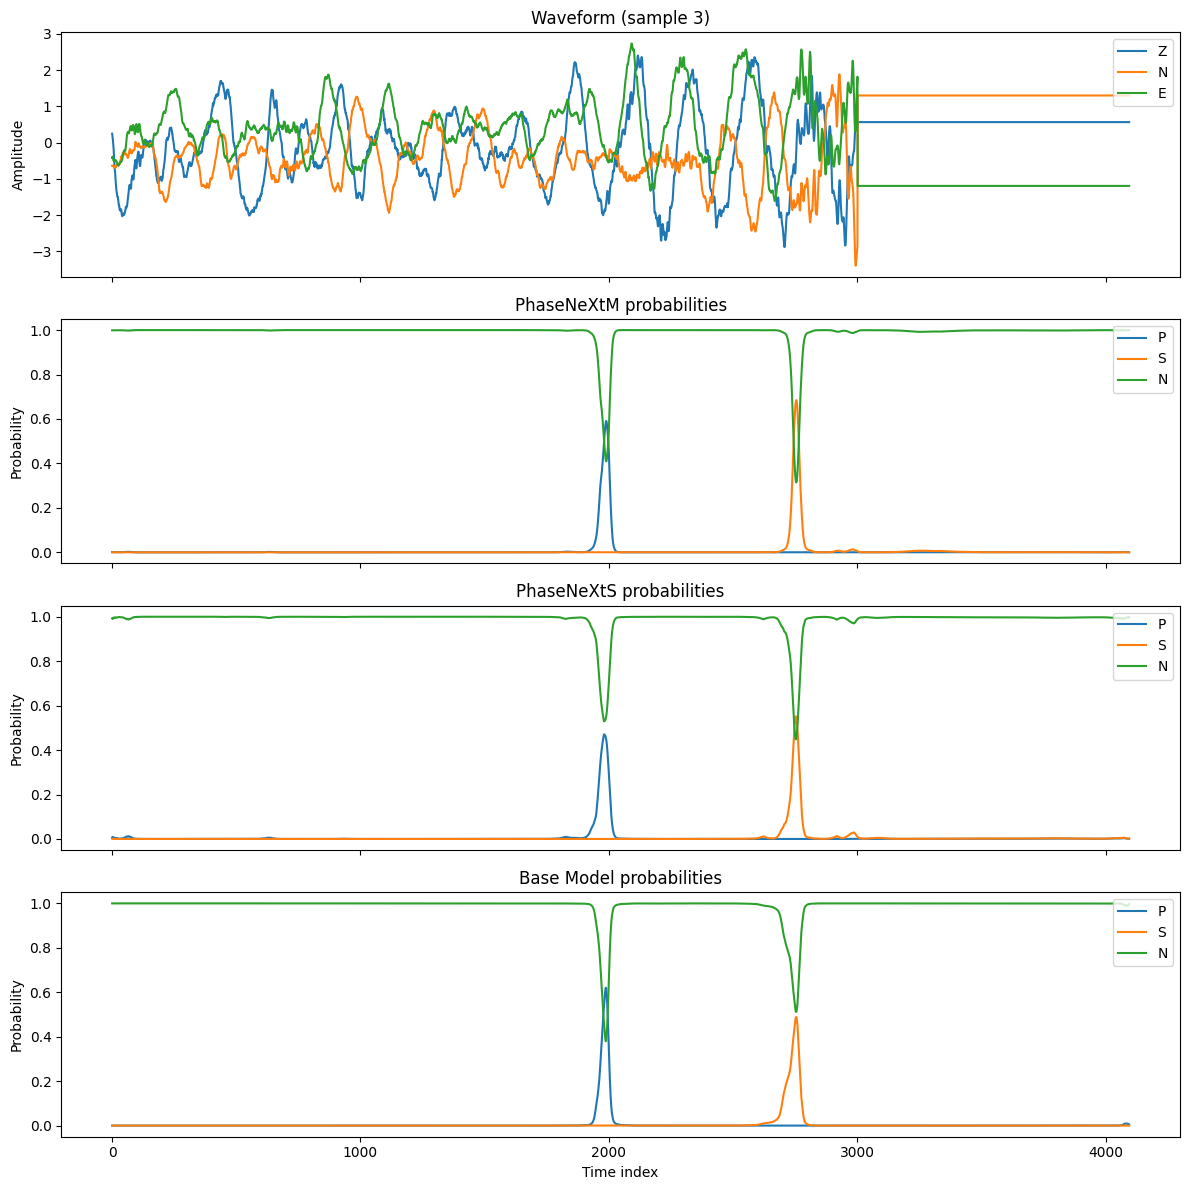

In [5]:
sample_idx = 3
time_indices = np.arange(wv_tensor.shape[2])

fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
axes[0].plot(time_indices, wv_tensor[sample_idx].numpy().T)
axes[0].set_title(f"Waveform (sample {sample_idx})")
axes[0].set_ylabel("Amplitude")
axes[0].legend(["Z", "N", "E"], loc="upper right")

axes[1].plot(time_indices, pred_NeXtM[sample_idx].T)
axes[1].set_title("PhaseNeXtM probabilities")
axes[1].set_ylabel("Probability")
axes[1].legend(["P", "S", "N"], loc="upper right")

axes[2].plot(time_indices, pred_NeXtS[sample_idx].T)
axes[2].set_title("PhaseNeXtS probabilities")
axes[2].set_ylabel("Probability")
axes[2].legend(["P", "S", "N"], loc="upper right")

axes[3].plot(time_indices, pred_base[sample_idx].T)
axes[3].set_title("Base Model probabilities")
axes[3].set_ylabel("Probability")
axes[3].legend(["P", "S", "N"], loc="upper right")
axes[3].set_xlabel("Time index")

fig.tight_layout()